First Phase Environment implemented according to scratch notes from call on 12/11/20

In [1]:
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#plt.ioff() # for py work
import numpy as np
import os
import pandas as pd
import copy
import random
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import hypergeom
from scipy.integrate import odeint

from tf_agents.environments import py_environment
from tf_agents.specs import BoundedArraySpec
from tf_agents.trajectories.time_step import StepType
from tf_agents.trajectories.time_step import TimeStep

# Documentation
Env_P1 is a class that represents an epidemic with two herds.  

<img src="Sketch.jpeg"
     alt="Env_P1 Sketch"
     style="float: left; margin-right: 5px;" />
## Variables:  
The action $\in \mathbb{R}^4$ is a vector $(\tau_1, \tau_2, s_1, s_2)$.  
$\tau_i$ are the number of tests to be done in herd $i$.  
$s_i \in \{0,1\}$ determine whether a herd is to be completely replaced by healthy members.  
$S_i$ is the number of susceptible herd members (subjects) of herd $i$, $i \in {0,1}$.  
$I_i$ is the number of infectious subjects of herd $i$, $i \in {1,2}$.  
$g$ is a small recovery probability.  
$q$ is a small infection probability.  
$B_i' = min(B_i,|S_i|-1)$ with $B_i = \sum_{I_i} A$ and $A \sim Poi(0.01)$, is the number of Susceptibles moving to Infectious per time step for herd $i$, $i \in {1,2}$.  
## State  
The state contains two arrays of size six. 
state[0] is the observation shown to the agent.  
The observation are testresults for each herd $(\mu_i, x^i_0, x^i_1)$.  
$\mu_i$ shows the number of time steps since the test has been done.  
$x^i_0$ and $x^i_1$ correspond to negative and positive testresults respectively.  

state[1] instead contains the internal information about both herds.  
state[1][i] shows the population size for herd i.  
state[1][i+2] shows the total number of infected subjects for herd i.  
## Reward  
Reward calculation respects costs for tests and herd replacement.  
Let $R$ be the current reward (starts at zero). Then each time step:  

$R - \tau_i * c + 1_{\tau_i} * cprime, \forall i \in \{0,1\}$,  
$R - s_i * state[1][i] * e, \forall i \in \{0,1\}$. 
  
Here, $c$, $cprime > c$ and $e$ are constants.  
Also, reduces reward by number of infectious:  

$R - state[1][i+2], \forall i \in \{0,1\}$. 


In [2]:
class P_Env_P1(py_environment.PyEnvironment):
    def __init__(self,
                root_dir, #path for plotting
                global_step = 0, #ID for plotting
                population_herd1 = 200,
                population_herd2 = 50,
                exchanged_members = 5,
                weeks_until_exchange = 4,
                rand_recovery_prob = 0.005,
                rand_infection_prob = 0.01,
                ):
        super(P_Env_P1, self).__init__()
        self._state = None
        self._observation = None
        self._discount = np.float32(1)
        self._time = 0
        self._episode_length = 0
        self._tests = []
        self._reward = np.float32(0)
        self._c_tests = 1    #cost for each test
        self._c_prime_tests = 50    #organizational costs tests
        self._e_removed = 10    #individual replacement cost
        self._weeks_until_testresults = 3
        self._population_herd1 = population_herd1
        self._population_herd2 = population_herd2
        self._exchanged_members = exchanged_members    #k from scrapsheet
        self._weeks_until_exchange = weeks_until_exchange    #T from scrapsheet
        self._rand_recovery_prob = rand_recovery_prob    #g from scrapsheet
        self._rand_infection_prob = rand_infection_prob    #q from scrapsheet
        
        self._actions = []
        self._states = []
        self._root_dir = root_dir
        self._global_step = global_step
    
    def action_spec(self):
        #Actions for: number of subjects to be tested h1, h2. number of subjects to be eliminated h1, h2
        return BoundedArraySpec((4,), np.float32, minimum=0, maximum=1)
    
    
    def observation_spec(self):
        # tau, x0, x1 for both herds
        return BoundedArraySpec((6,), np.int32, minimum=0, maximum=2000)
    
    
    def _reset(self):
        '''
        State consists of actual state of each herd (population and infected, state[1]),
        and observation the agent gets to see (state[0]).
        state[0] contains:
        number of steps since test has taken place,
        number of positive tests,
        number of negative tests
        for each herd.  
        '''
        self._actions = []
        self._states = []
        self._state = np.zeros((4,), np.int32)
        initial_infected_h1 = np.random.randint(low = 1, high = (self._population_herd1/8))
        self._time = 0
        self._reward = np.float32(0)
        self._episode_length = geom.rvs(p = 1/270)
        self._state[3] = 0    #infected h2
        self._state[2] = initial_infected_h1    #infected h1
        self._state[1] = self._population_herd2
        self._state[0] = self._population_herd1
        self._observation = np.zeros((6,), np.int32)
        self._states.append(self._state)
        return TimeStep(StepType.FIRST, reward=self._reward,
                    discount=self._discount, observation = self._observation)
    
    def _test(self, herd = -1, num_tests = 0):
        '''
        Randomly draws (without returning) num_tests subjects of a herd,
        then tests whether they are infected or not before returning testresults.
        '''
        assert self._state[herd] >= num_tests, "More tests than herd members."
        if herd >= 0 and num_tests > 0:
            test_out = hypergeom.rvs(M = self._state[herd], n = self._state[herd+2], N = int(num_tests), size = 1)
            testresults = np.zeros(3, np.int32)
            testresults[1] = num_tests - test_out #negative tests
            testresults[2] = test_out #positive tests
            return testresults
        else:
            return np.zeros(3, np.int32)
        
    def _transfer(self, origin_herd = -1, target_herd = -1):
        ''' 
        Each self._weeks_until_exchange weeks, transfers subjects 
        from origin_herd to target_herd by randomly drawing (without return)
        self._exchanged_members subjects from all subjects of origin_herd.
        returns numbers of infected transfers and susceptible transfers.'''
        #failsafe for k>n?
        assert self._state[origin_herd] > self._exchanged_members, "Population in origin herd too low."
        if origin_herd >= 0 and target_herd >=0 and self._time % self._weeks_until_exchange == 0:
            infected_transfers = hypergeom.rvs(M = self._state[origin_herd], 
                                                 n = self._state[origin_herd+2], N = self._exchanged_members, size = 1)
            susceptible_transfers = self._exchanged_members - infected_transfers
            return np.array([susceptible_transfers, infected_transfers])    
        else:
            return None
        
    def _model(self, action: np.ndarray, s1 = False, s2 = False):
        '''
        Completes one time step in a herd (i.e. excluding transfers and tests).
        In f(x), samples new infections from poisson dist with lambda = 0.6,
        also considers spontaneous infection and recovery factors.
        Then, depending on whether a herd is to be replaced by healthy subjects (action),
        calls f(x) or simply replaces all subjects by healthy subjects for each herd.
        '''
        
        initial_state = self._state
        #Model for one herd
        def f(x):
            s_to_i = 0
            for i in range (0, round(x[1])):
                s_to_i += poisson.rvs(0.01)
            s_to_i = round(min(s_to_i, x[0]))
            dsdt = x[0] - s_to_i - round(self._rand_infection_prob * x[0]) + round(self._rand_recovery_prob * x[1])
            didt = x[1] + s_to_i + round(self._rand_infection_prob * x[0]) - round(self._rand_recovery_prob * x[1])
            return np.array([dsdt, didt])
        
        #One step for each herd
        if s1:
            initial_state_h2 = [self._state[1]-self._state[3], self._state[3]]
            S1, I1 = [self._state[0], 0]
            S2, I2 = f(x = initial_state_h2)
        elif s2: 
            initial_state_h1 = [self._state[0]-self._state[2], self._state[2]]
            S1, I1 = f(x = initial_state_h1)
            S2, I2 = [self._state[1], 0]
        else:
            initial_state_h1 = [self._state[0]-self._state[2], self._state[2]]
            initial_state_h2 = [self._state[1]-self._state[3], self._state[3]]
            S1, I1 = f(x = initial_state_h1)
            S2, I2 = f(x = initial_state_h2)
        return np.array([S1+I1, S2+I2, I1, I2])
    
    def _reward_func(self, action: np.ndarray):
        '''
        Calculates and returns reward.
        R -= tau_i * C + Indicator_i * C_prime
        Where tau_i is number of tests in each herd, 
        Indicator_i is whether tau_i > 0 and C < C_prime.
        R -= s_i * population_herd_i * replacement_cost
        Where s_i is indicator for whether a herd was replaced by healthy subjects
        and replacement_cost is a constant representing the cost of replacing a single subject.
        '''
        tau_1 = np.round(action[0] * self._state[0]) 
        tau_2 = np.round(action[1] * self._state[1])
        indicator_1, indicator_2, s1, s2 = 0, 0, 0, 0 
        if action[2] > 1/2 and action[3] <= 1/2:
            s1 = 1
        if action[3] > 1/2 and action[2] <= 1/2:
            s2 = 1
        if tau_1 > 0:
            indicator_1 = 1
        if tau_2 > 0:
            indicator_2 = 1
        self._reward -= self._discount * (tau_1 * self._c_tests + indicator_1 * self._c_prime_tests)
        self._reward -= self._discount * (tau_2 * self._c_tests + indicator_2 * self._c_prime_tests)
        self._reward -= self._discount * (s1 * self._state[0] * self._e_removed + s2 * self._state[1] * self._e_removed)
        self._reward -= self._discount * (self._state[2] + self._state[3])
        return self._reward
    
    def plot_action(self, action: np.ndarray):
        t = np.linspace(0, self._time, num=len(self._actions))
        fig = plt.figure(figsize=(15,12))
        fig, (p1,p2) = plt.subplots(1, 2, figsize=(20,10))
        fig.suptitle('Actions over Time')
        p1.set_title('Tests over Time')
        p1.set_xlabel('Time')
        p1.set_ylabel('Number of Tests')
        p2.set_title('Herd Replacement over Time')
        p2.set_xlabel('Time')
        p2.set_ylabel('Replacement')
        root_dir = self._root_dir
        root_dir = os.path.expanduser(root_dir) 
        fnm = os.path.join(root_dir, 'Actions' + '_' + str(self._time) + '_' + str(self._global_step)) 
        ntests1 = []
        ntests2 = []
        sone = []
        stwo = []
        for i in range(len(self._actions)):
            ntests1.append(self._actions[i][0])
            ntests2.append(self._actions[i][1])
            sone.append(self._actions[i][2])
            stwo.append(self._actions[i][3])
        p1.plot(t, ntests1, color='blue', label = '% Tests Herd 1', marker = '.', linestyle = '')
        p1.plot(t, ntests2, color='red', label = '% Tests Herd 2', marker = '.', linestyle = '')
        p2.plot(t, sone, color='blue', label = 'Replace Herd 1', marker = '.', linestyle = '')
        p2.plot(t, stwo, color='red', label = 'Replace Herd 2', marker = '^', linestyle = '')
        plt.savefig(fnm + '.jpg',bbox_inches='tight', dpi=150)
        return None
    
    def _step(self, action: np.ndarray):
        '''
        Step completes one time step in the environment.
        First, transfers subjects if time interval dictates it.
        Then, calls model(action) to complete a time step in each herd.
        Afterwards, tests subjects if action dictates it and outputs testresults
        if time for testing has been concluded.
        Finally, calculates reward and returns a Time_Step object.
        TimeStep(StepType.MID, reward=reward, discount=self._discount, observation=[self._state[0]])
        
        TODOS: Check chronology
        '''
        if self._current_time_step.is_last():
            return self.reset()
        
        self._time += 1
        origin_herd = 0
        target_herd = 1
        transfers = self._transfer(origin_herd = origin_herd, target_herd = target_herd)
        back_transfers = self._transfer(origin_herd = target_herd, target_herd = origin_herd)
        if transfers is not None:
            self._state[origin_herd] = self._state[origin_herd] - transfers[0] - transfers[1] + back_transfers[0] + back_transfers[1]
            self._state[target_herd] = self._state[target_herd] + transfers[0] + transfers[1] - back_transfers[0] - back_transfers[1]
            self._state[origin_herd+2] = self._state[origin_herd+2] - transfers[1] + back_transfers[1]
            self._state[target_herd+2] = self._state[target_herd+2] + transfers[1] - back_transfers[1]
            
        #interpreting actions
        num_test_h1 = np.round(action[0] * self._state[0])
        num_test_h2 = np.round(action[1] * self._state[1])
        
        rem_h1 = False
        rem_h2 = False
        if action[2] > 1/2 and action[3] <= 1/2:
            rem_h1 = True
        if action[3] > 1/2 and action[2] <= 1/2:
            rem_h2 = True
            
        #Model should make a step in between transfer and test
        self._state = self._model(action, s1 = rem_h1, s2 = rem_h2)
        
        #Testing 
        self._tests.append(self._test(herd = 0, num_tests = num_test_h1))
        self._tests.append(self._test(herd = 1, num_tests = num_test_h2))
        
        for i in range (0, np.ma.size(self._tests, axis = 0)):
            if self._tests[i][0] == self._weeks_until_testresults:
                self._observation[5] = self._tests[i+1][2]    #x1 tested pos h2
                self._observation[4] = self._tests[i+1][1]    #x0 tested neg h2
                self._observation[3] = self._weeks_until_testresults    
                self._observation[2] = self._tests[i][2]    #x1 tested pos h1
                self._observation[1] = self._tests[i][1]    #x0 tested neg h1
                self._observation[0] = self._weeks_until_testresults
                self._tests.pop(i)
                self._tests.pop(i)
                break
        for i in range (0, np.ma.size(self._tests, axis = 0)):
            self._tests[i][0] += 1 
            
        #Reward function
        reward = np.float32(self._reward_func(action))
        
        #Debugging
        if self._time % 100 == 0:
            print('Hidden State: ', self._state)
            print('Observation: ', self._observation)
    
        #Plotting
        action_f = action
        if action[2] > 1/2 and action[3] <= 1/2:
            action_f[2] = 1
        else:
            action_f[2] = 0 
        if action[3] > 1/2 and action[2] <= 1/2:
            action_f[3] = 1
        else: 
            action_f[3] = 0
        
        if (self._time % 5 == 0):
            self._actions.append(action_f)
            self._states.append(self._state)
        
        #output
        if self._time == self._episode_length:
            figure = self.plot_action(action)
            return TimeStep(StepType.LAST, reward=reward, discount=self._discount, observation=self._observation)
            #return TimeStep(StepType.LAST, reward=reward, discount=self._discount, observation=np.array([self._state[0]]))
        else:
            return TimeStep(StepType.MID, reward=reward, discount=self._discount, observation=self._observation)
            #return TimeStep(StepType.MID, reward=reward, discount=self._discount, observation=np.array([self._state[0]]))

Hidden State:  [200  50   0   0]
Observation:  [ 3 85  2  3 14  0]
Hidden State:  [200  50  20   0]
Observation:  [  3 124   9   3  46   0]
Hidden State:  [200  50   2   0]
Observation:  [ 3 58  0  3 31  0]
Hidden State:  [200  50   8   0]
Observation:  [  3 187   2   3  36   1]
Hidden State:  [200  50   2   1]
Observation:  [ 3 52  4  3 32  1]
Hidden State:  [200  50   5   0]
Observation:  [ 3 80  0  3 48  0]


<Figure size 1080x864 with 0 Axes>

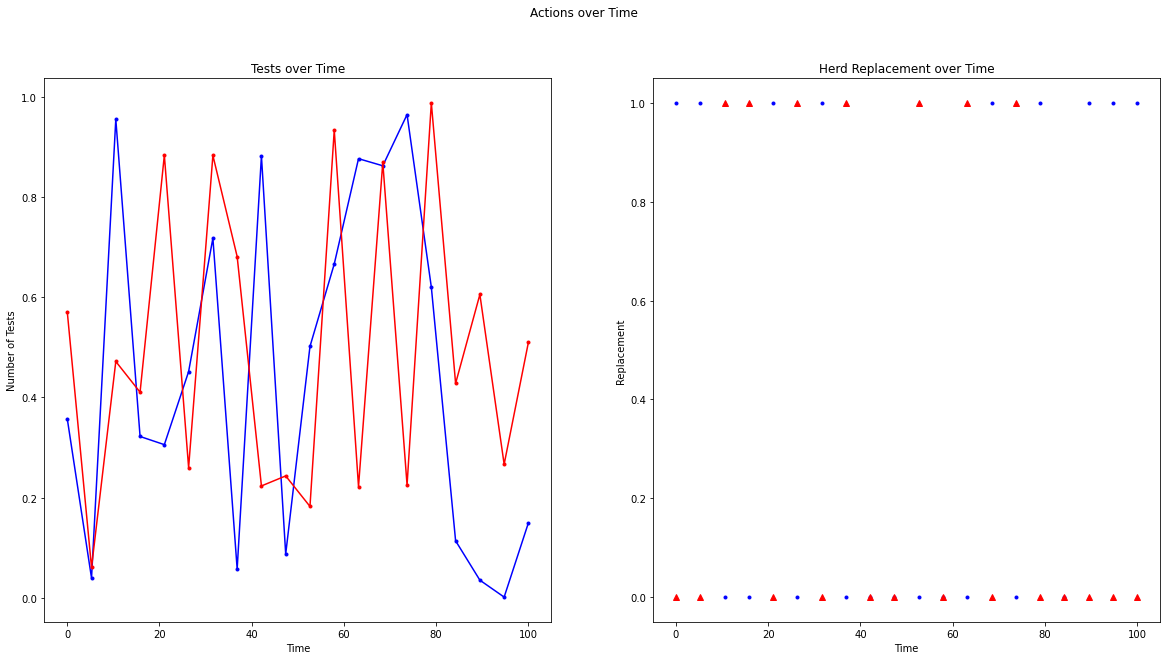

<Figure size 1080x864 with 0 Axes>

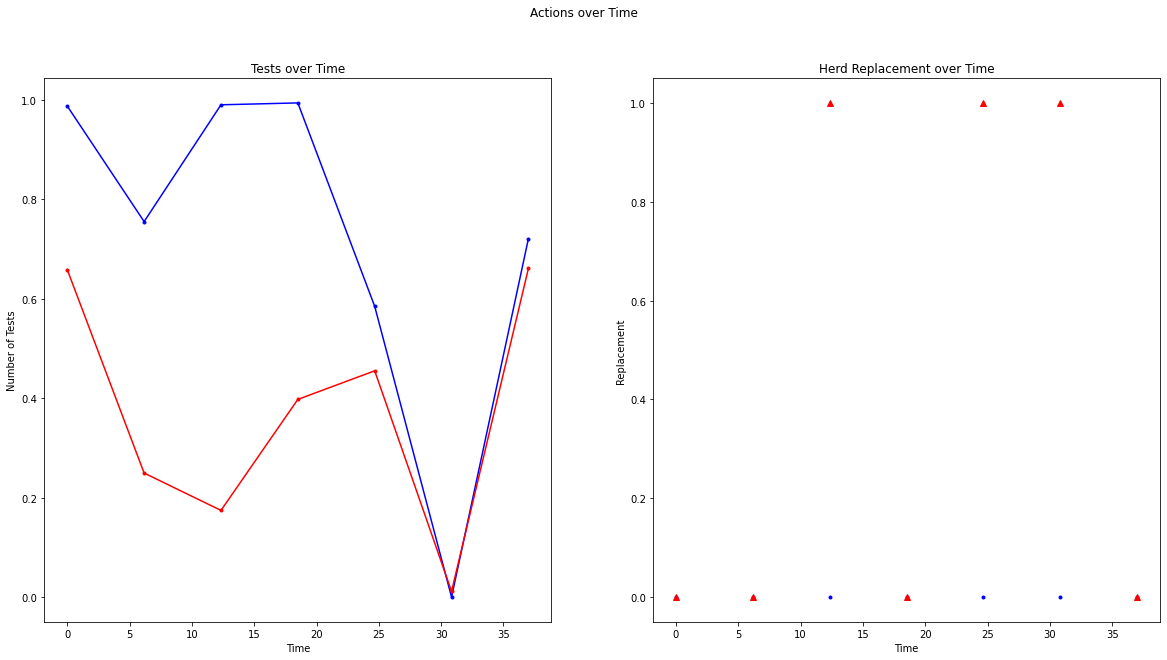

<Figure size 1080x864 with 0 Axes>

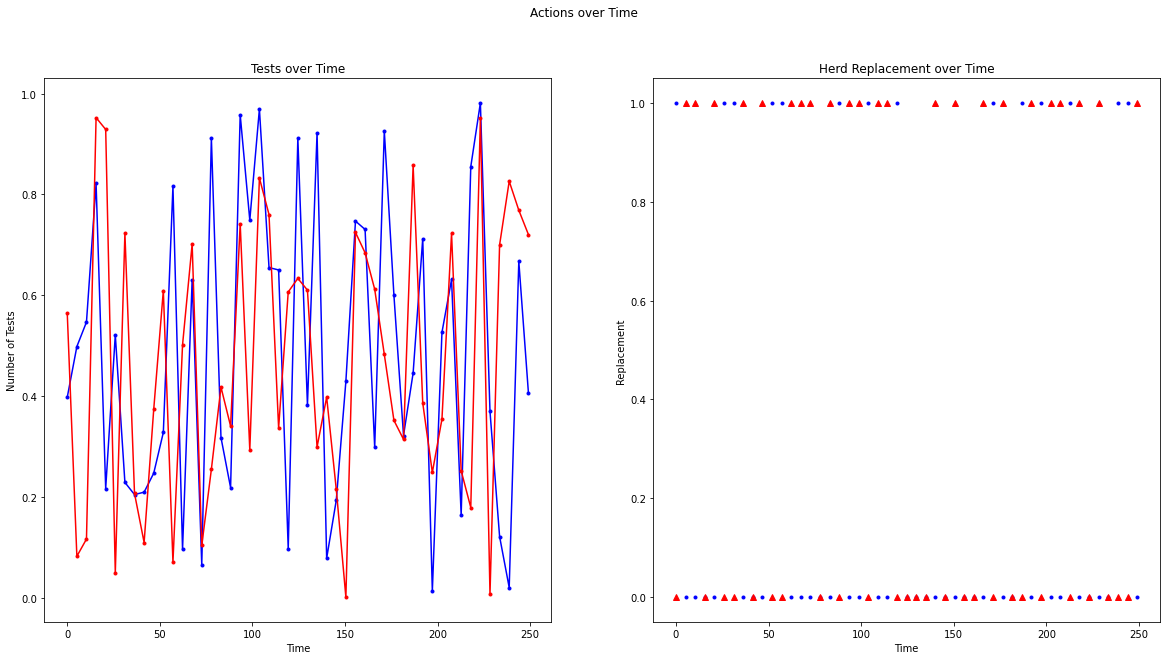

<Figure size 1080x864 with 0 Axes>

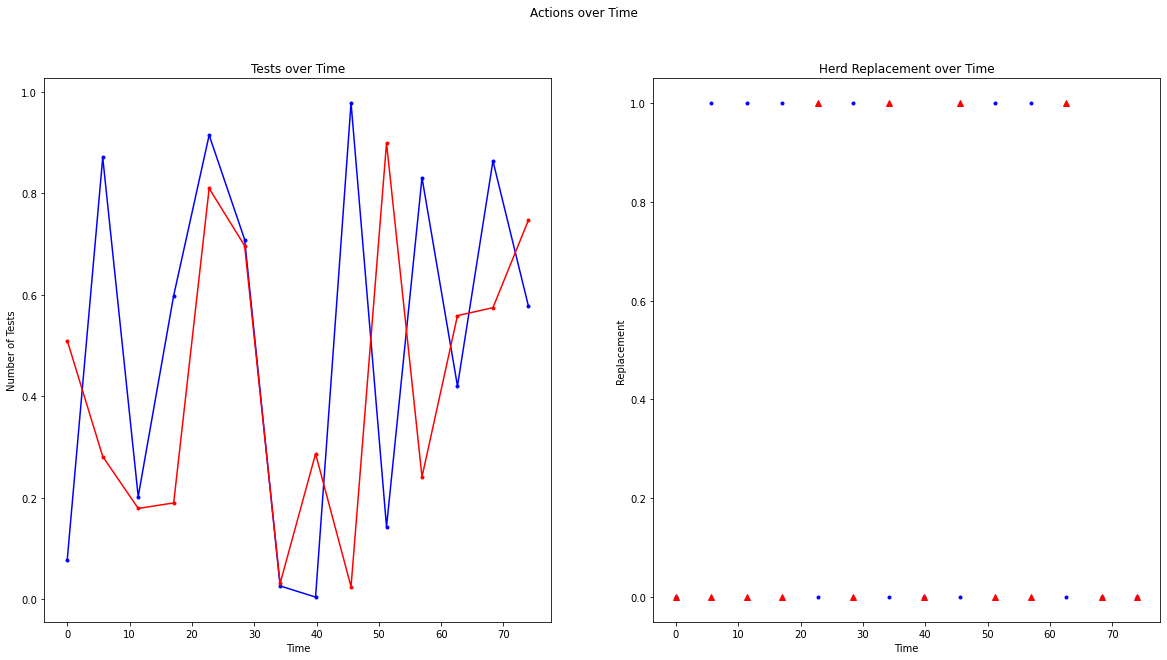

<Figure size 1080x864 with 0 Axes>

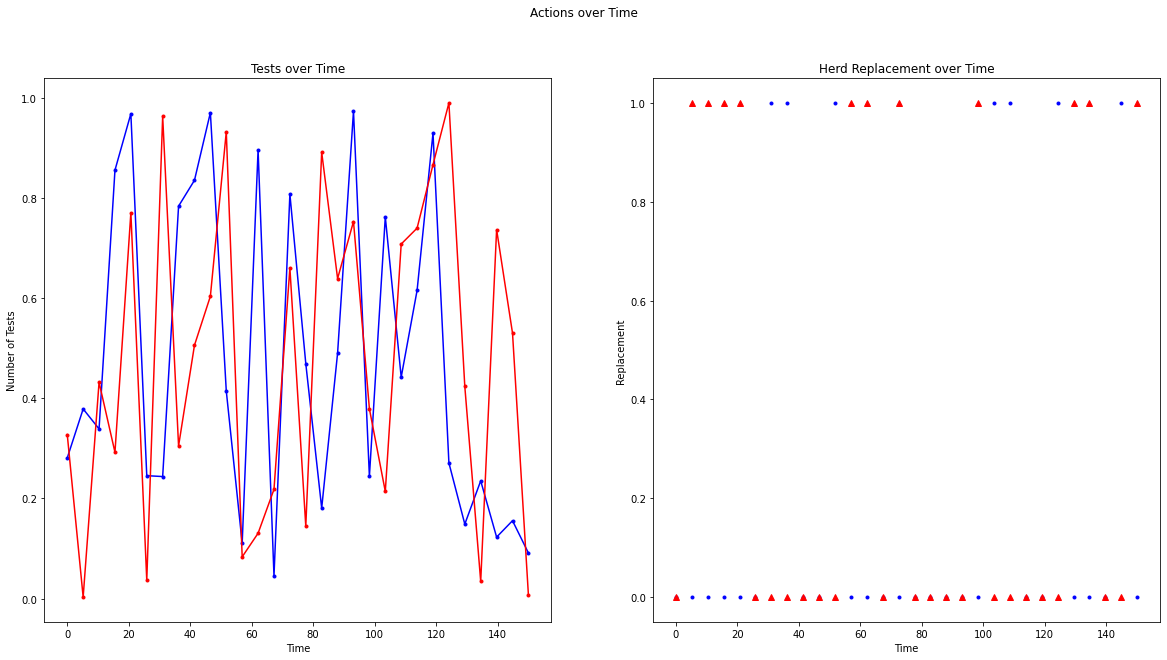

<Figure size 1080x864 with 0 Axes>

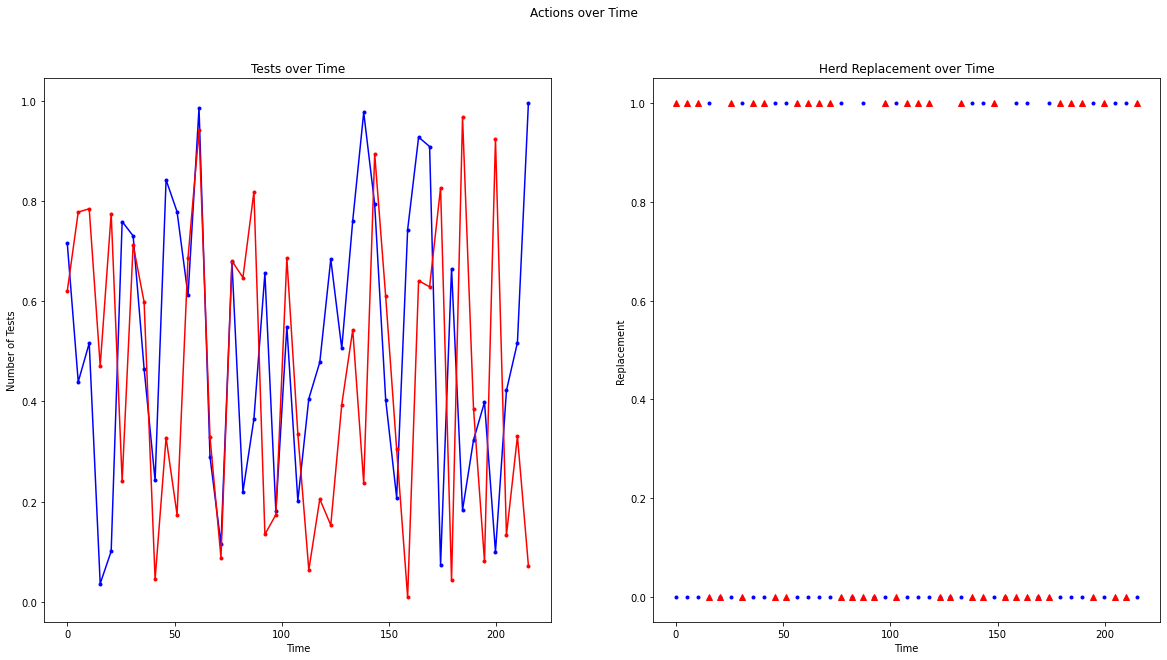

<Figure size 1080x864 with 0 Axes>

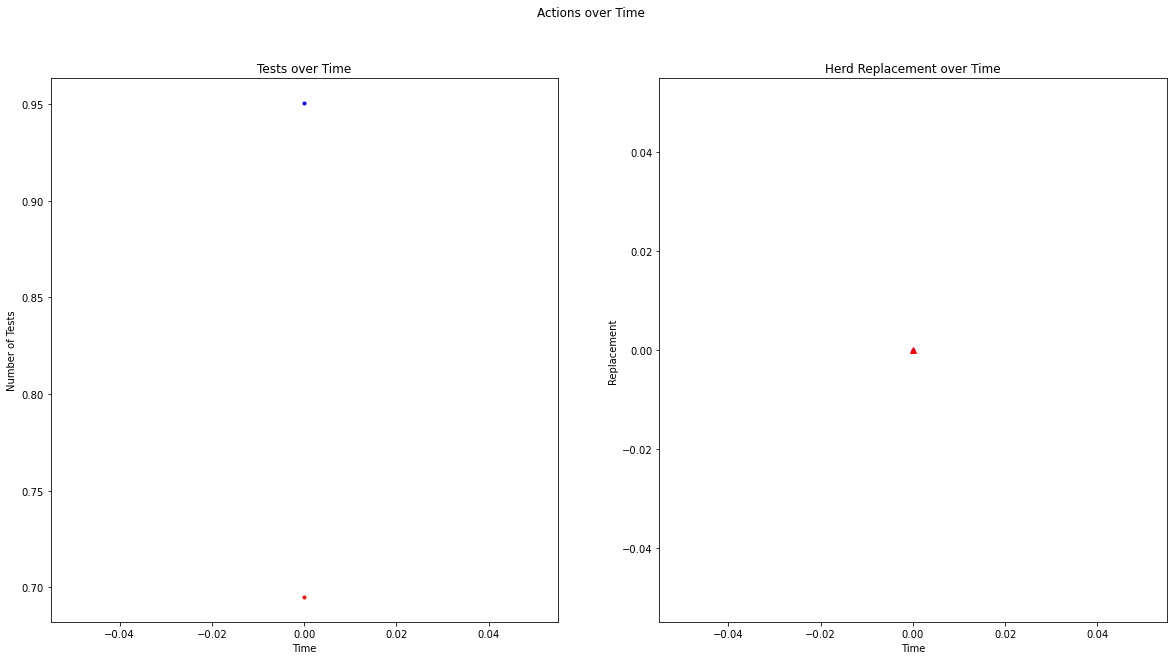

<Figure size 1080x864 with 0 Axes>

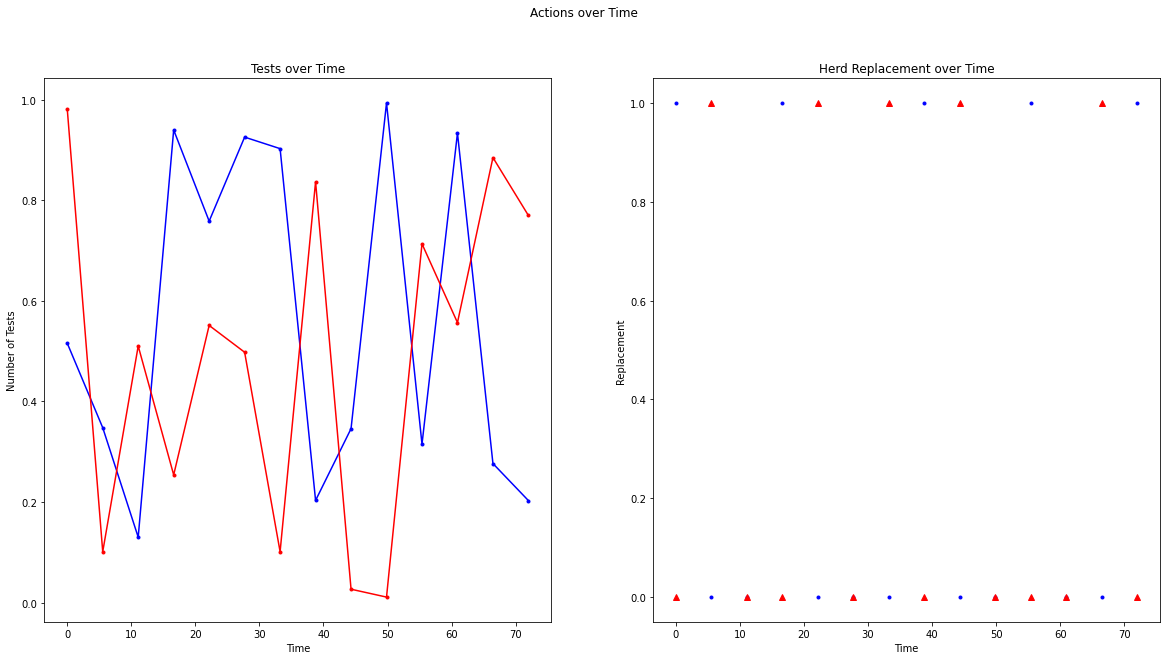

In [3]:
env = P_Env_P1(root_dir = '~/Masterarbeit/testplots',global_step = 20)
env.reset()
for i in range (1,1000):
    env.step([np.random.uniform(low=0.0, high=1.0, size=None), 
              np.random.uniform(low=0.0, high=1.0, size=None), 
              np.random.uniform(low=0.0, high=1.0, size=None), 
              np.random.uniform(low=0.0, high=1.0, size=None)])